In [280]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from pigeon import annotate
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
import pickle

import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [10]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Labeling

In [56]:
DATA_MODES = ['train', 'test']
DEVICE = torch.device("cuda")

In [57]:
DATA_DIR = Path('EyesDataset/')
files = sorted(list(DATA_DIR.rglob('*.jpg')))

In [ ]:
from IPython.display import display, Image

In [3]:
annotations = annotate(
  files,
  options=['opened', 'closed'],
  display_fn=lambda filename: display(Image(filename))
)

HTML(value='0 examples annotated, 4001 examples left')

Output()

Annotation done.


In [6]:
with open('annotations.pkl', 'wb') as f:
    pickle.dump(annotations, f)

In [473]:
with open('annotations.pkl', 'rb') as f:
    annotations = pickle.load(f)

In [474]:
len(annotations)

3955

In [477]:
labels = np.array([x for _, x in annotations])

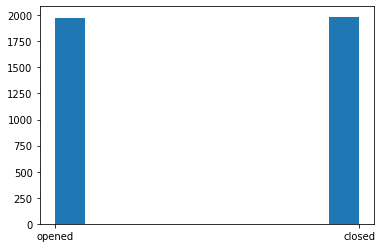

In [480]:
_ = plt.hist(labels)

In [24]:
train_ann, test_ann = train_test_split(annotations, test_size=0.1, shuffle=True)

# Dataset class

In [59]:
from PIL import Image 

In [210]:
class EyesDataset(Dataset):
    def __init__(self, annotations, mode):
        super().__init__()
        self.annotations = annotations
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.annotations)
     
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        
        augmentation = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(24, scale=(0.8, 1), ratio=(0.75, 1.3333333333333333), interpolation=2),
#             transforms.RandomPerspective(distortion_scale=0.3, p=0.9, interpolation=3, fill=0),
            transforms.RandomAffine(degrees=20, shear=20, resample=False),
            transforms.Resize((24, 24))
        ])
        
        x = self.load_sample(self.annotations[index][0])
        label = (lambda x : 0 if (x == 'closed') else 1)(self.annotations[index][1])
        label = np.array(label, dtype='float32')
                                                         
        if self.mode == 'train':
            x = augmentation(x)
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        return x, label
        
    def _prepare_sample(self, image):
        image = image.resize((24, 24))
        return np.array(image)

In [211]:
train_dataset = EyesDataset(train_ann, 'train')
test_dataset = EyesDataset(test_ann, 'test')

In [212]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)

# Train functions

In [248]:
def train_epoch(net, train_loader, loss_fn, optimizer):
    net.train()
    train_ep_loss = 0.
    counter = 0
    for train_x, train_y in train_loader:
        train_x = train_x.to(DEVICE)
        train_y = train_y.to(DEVICE).view(-1, 1)
        # zero  gradients
        optimizer.zero_grad()

        # get the output from the model
        output = net(train_x)
        output = torch.sigmoid(output)
        # calculate loss
        loss = loss_fn(output, train_y)
        loss.backward()
        optimizer.step()

        train_ep_loss += loss.item() 
        counter += 1
    train_ep_loss /= counter
   
    return train_ep_loss

In [386]:
def test_epoch(net, test_loader, loss_fn):
    net.eval()
    test_ep_loss = 0.
    test_ep_acc = 0.
    test_ep_f1 = 0.
    
    counter = 0.
    for test_x, test_y in test_loader:
        test_x = test_x.to(DEVICE)
        test_y = test_y.to(DEVICE).view(-1, 1)
        
        output = net(test_x)
        output = torch.sigmoid(output)
        
        # calculate loss and metrics
        loss = loss_fn(output, test_y)
        acc = accuracy_score(test_y.cpu().detach(), (output.cpu().detach() > 0.5))
        f1 = f1_score(test_y.cpu().detach(), (output.cpu().detach() > 0.5).type(torch.float32))
        
        test_ep_loss += loss.item() 
        test_ep_acc += acc
        test_ep_f1 += f1
        
        counter += 1

    test_ep_loss /= counter
    test_ep_acc /= counter
    test_ep_f1 /= counter
    
    return test_ep_loss, test_ep_acc, test_ep_f1

In [397]:
def train(net, train_loader, test_loader, loss_fn, optimizer, epochs, scheduler=None):
    
    train_losses = []
    test_losses = []

    for e in tqdm(range(epochs)):

        train_loss = train_epoch(net, train_loader, loss_fn, optimizer)
        if scheduler:
            scheduler.step()
        with torch.no_grad():
            test_loss, test_acc, test_f1 = test_epoch(net, test_loader, loss_fn)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        if e%5 == 0:
            print("Epoch: {}/{}...".format(e+1, epochs),
                          "Loss: {:.6f}...".format(train_loss),
                          "Test Loss: {:.6f}...".format(test_loss), 
                          "Test acc: {:.6f}".format(test_acc),
                          "Test f1: {:.6f}".format(test_f1))
    return train_losses, test_losses

# Model

In [452]:
mobilenet = models.mobilenet_v2()

In [453]:
mobilenet.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [454]:
mobilenet.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False), 
    nn.Linear(in_features=1280, out_features=100, bias=True), 
    nn.ReLU(), 
    nn.Linear(in_features=100, out_features=1, bias=True)
)

# Train

In [455]:
mobilenet = mobilenet.to(DEVICE)

optimizer = torch.optim.Adam(mobilenet.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)
criterion = nn.BCELoss()

In [456]:
mn_train_loss, mn_test_losses = train(mobilenet, train_loader, test_loader, criterion, optimizer, 40, scheduler)

  2%|▎         | 1/40 [00:07<04:41,  7.23s/it]

Epoch: 1/40... Loss: 0.647658... Test Loss: 0.588354... Test acc: 0.702724 Test f1: 0.727825


 15%|█▌        | 6/40 [00:42<04:02,  7.13s/it]

Epoch: 6/40... Loss: 0.376040... Test Loss: 0.296225... Test acc: 0.871795 Test f1: 0.883527


 28%|██▊       | 11/40 [01:18<03:28,  7.20s/it]

Epoch: 11/40... Loss: 0.316134... Test Loss: 0.217810... Test acc: 0.925481 Test f1: 0.926364


 40%|████      | 16/40 [01:54<02:51,  7.14s/it]

Epoch: 16/40... Loss: 0.302945... Test Loss: 0.212231... Test acc: 0.931090 Test f1: 0.931773


 52%|█████▎    | 21/40 [02:29<02:12,  6.98s/it]

Epoch: 21/40... Loss: 0.314267... Test Loss: 0.219511... Test acc: 0.923878 Test f1: 0.925836


 65%|██████▌   | 26/40 [03:04<01:37,  6.97s/it]

Epoch: 26/40... Loss: 0.299854... Test Loss: 0.205403... Test acc: 0.942308 Test f1: 0.941840


 78%|███████▊  | 31/40 [03:39<01:03,  7.08s/it]

Epoch: 31/40... Loss: 0.317097... Test Loss: 0.214147... Test acc: 0.933494 Test f1: 0.935276


 90%|█████████ | 36/40 [04:14<00:28,  7.04s/it]

Epoch: 36/40... Loss: 0.299019... Test Loss: 0.227404... Test acc: 0.923077 Test f1: 0.923938


100%|██████████| 40/40 [04:43<00:00,  7.08s/it]


In [457]:
torch.save(mobilenet.state_dict(), 'weights_mn_40.pth')

In [495]:
def openEyeCheck(inpIm, model=None):
    def load_sample(file):
        image = Image.open(file)
        image.load()
        return image
    if model is None:
        model = models.mobilenet_v2()
        model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False), 
            nn.Linear(in_features=1280, out_features=100, bias=True), 
            nn.ReLU(), 
            nn.Linear(in_features=100, out_features=1, bias=True)
        )
        model = model.to(DEVICE)
        model.load_state_dict(torch.load('weights_mn_40.pth'))
        model.eval()
    
    image = torch.FloatTensor(np.array(load_sample(inpIm))).to(DEVICE).view(1,1,24,24) / 255
    out = torch.sigmoid(model(image)) > 0.5
    
    if out.item():
        return 'Opened'
    return 'Closed'

In [496]:
openEyeCheck('EyesDataset/000000.jpg')

'Opened'